# Series de Tiempo
## Ejemplos con IBM & Walmart 
Katlyn Goeujon-Mackness <br>
28-04-2025

Considera la información histórica diaria de precios para las empresas IBM y Walmart contenida en el sitio de Yahoo finance (http://finance.yahoo.com) durante los últimos 5 años. 

In [2]:
# Cargar librerías 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ibm = yf.download(tickers='ibm', period = '5y', interval = '1d', rounding=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
ibm = ibm['Close']
ibm

Ticker,IBM
Date,
2020-04-28,96.02
2020-04-29,97.87
2020-04-30,95.48
2020-05-01,92.68
2020-05-04,92.53
...,...
2025-04-22,240.90
2025-04-23,245.48
2025-04-24,229.33


In [5]:
wmt = yf.download(tickers='wmt', period = '5y', interval = '1d', rounding=True)

[*********************100%***********************]  1 of 1 completed


In [9]:
wmt = wmt['Close']
wmt

Ticker,WMT
Date,
2020-04-28,39.65
2020-04-29,38.29
2020-04-30,37.65
2020-05-01,38.08
2020-05-04,38.32
...,...
2025-04-22,94.85
2025-04-23,94.96
2025-04-24,95.84


**¿Existe alguna correlación entre los precios de las acciones de ambas empresas?**
 Explica tanto de forma gráfica como a través del índice de correlación.

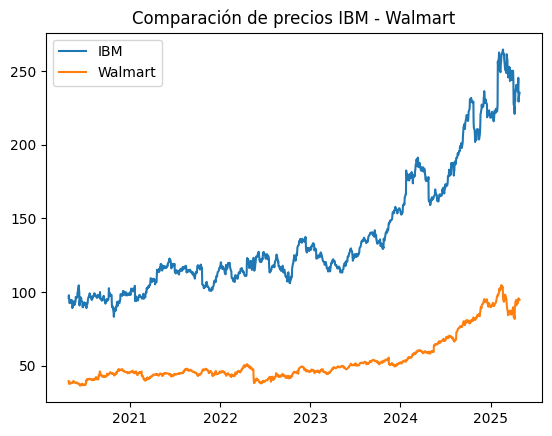

In [15]:
# Comparar los tickers 
plt.figure()
plt.plot(ibm, label="IBM")
plt.plot(wmt, label="Walmart")
plt.title('Comparación de precios IBM - Walmart')
plt.legend()
plt.show()

In [16]:
ibm_wmt = yf.download(tickers='ibm wmt', period = '5y', interval = '1d', rounding=True)
ibm_wmt = ibm_wmt['Close']

[*********************100%***********************]  2 of 2 completed


In [19]:
rend_ibm_wmt = ibm_wmt.pct_change()
rend_ibm_wmt

Ticker,IBM,WMT
Date,,
2020-04-28,NaN,NaN
2020-04-29,0.019267,-0.034300
2020-04-30,-0.024420,-0.016715
2020-05-01,-0.029326,0.011421
2020-05-04,-0.001618,0.006303
...,...,...
2025-04-22,0.019812,0.026404
2025-04-23,0.019012,0.001160
2025-04-24,-0.065789,0.009267


In [21]:
rend_ibm_wmt.dropna(inplace=True)
rend_ibm_wmt

Ticker,IBM,WMT
Date,,
2020-04-29,0.019267,-0.034300
2020-04-30,-0.024420,-0.016715
2020-05-01,-0.029326,0.011421
2020-05-04,-0.001618,0.006303
2020-05-05,0.007457,0.008351
...,...,...
2025-04-22,0.019812,0.026404
2025-04-23,0.019012,0.001160
2025-04-24,-0.065789,0.009267


In [22]:
correlacion = rend_ibm_wmt['IBM'].corr(rend_ibm_wmt['WMT'])
print("Correlación entre IBM y Walmart:", correlacion)

Correlación entre IBM y Walmart: 0.2058687006182558


### Descomposición
Obtén los gráficos de descomposición para ambas series de precios así como sus correlogramas.

### Interpretación

### Evaluación 
Aplica e interpreta la prueba de Dickey-Fuller para ambas series.

### Promedios Móviles
Haz un análisis gráfico de promedios móviles para ambas empresas y pronostica el siguiente día de cotizaciones. ¿Esperarías que dichos pronósticos sean buenos? Explica a detalle.